# Import Libraries

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score



# Load Dataset

In [4]:
 df=pd.read_csv('Walmart Data Analysis and Forcasting.csv')
 df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


# Check Missing values

In [5]:
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


# Create Time-Based Features

In [8]:
target = 'Weekly_Sales'

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek

for lag in [1, 2, 3, 7, 14]:
    df[f'lag_{lag}'] = df[target].shift(lag)

df['rolling_mean_7'] = df[target].shift(1).rolling(window=7).mean()
df['rolling_std_7'] = df[target].shift(1).rolling(window=7).std()

df = df.dropna().reset_index(drop=True)
print(df.head())

   Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1 2010-08-20    1513080.49             0        86.65       2.664   
1      1 2010-08-27    1449142.92             0        85.22       2.619   
2      1 2010-09-03    1540163.53             0        81.21       2.577   
3      1 2010-09-10    1507460.69             1        78.69       2.565   
4      1 2010-09-17    1430378.67             0        82.11       2.582   

          CPI  Unemployment  year  month  day  dayofweek       lag_1  \
0  211.603363         7.787  2010      8   20          4  1508237.76   
1  211.567306         7.787  2010      8   27          4  1513080.49   
2  211.531248         7.787  2010      9    3          4  1449142.92   
3  211.495190         7.787  2010      9   10          4  1540163.53   
4  211.522460         7.787  2010      9   17          4  1507460.69   

        lag_2       lag_3       lag_7      lag_14  rolling_mean_7  \
0  1605491.78  1371986.60  1492418.14  14

# Train/Test Split for Time Series

In [9]:
split = int(len(df)*0.8)
train = df[:split]
test = df[split:]

feature_cols = [col for col in df.columns if col not in ['Date', target]]
X_train, y_train = train[feature_cols], train[target]
X_test, y_test = test[feature_cols], test[target]


# Regression Model & Forecasting

In [16]:
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")


RMSE: 114643.14, MAE: 59179.67


# Plot Actual vs Predicted

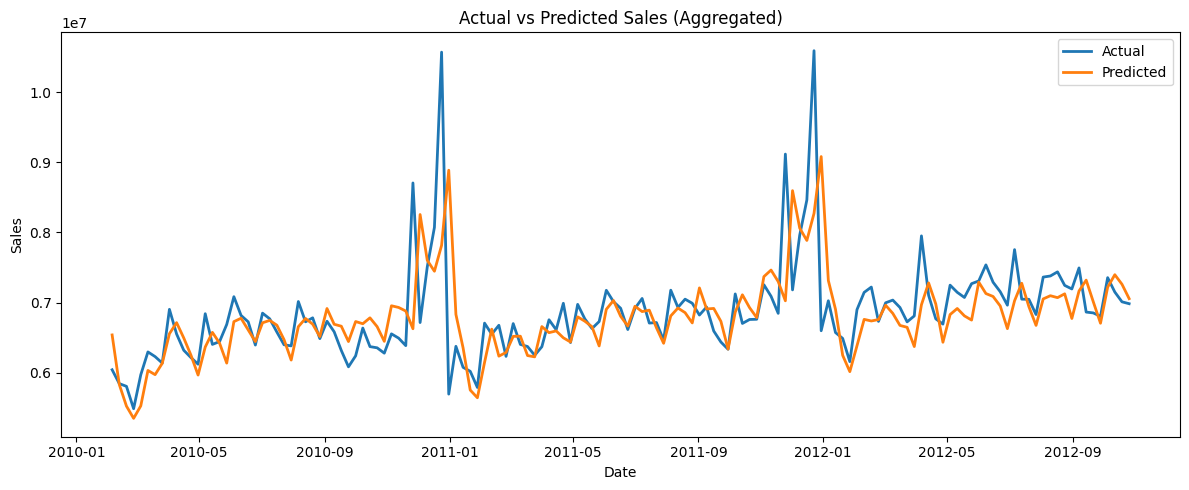

In [18]:
agg_test = test.groupby('Date')[target].sum().reset_index()
agg_pred = pd.DataFrame({'Date': test['Date'], 'Predicted': y_pred})
agg_pred = agg_pred.groupby('Date')['Predicted'].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(agg_test['Date'], agg_test[target], label="Actual", linewidth=2)
plt.plot(agg_pred['Date'], agg_pred['Predicted'], label="Predicted", linewidth=2)
plt.title("Actual vs Predicted Sales (Aggregated)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


# Rolling Averages

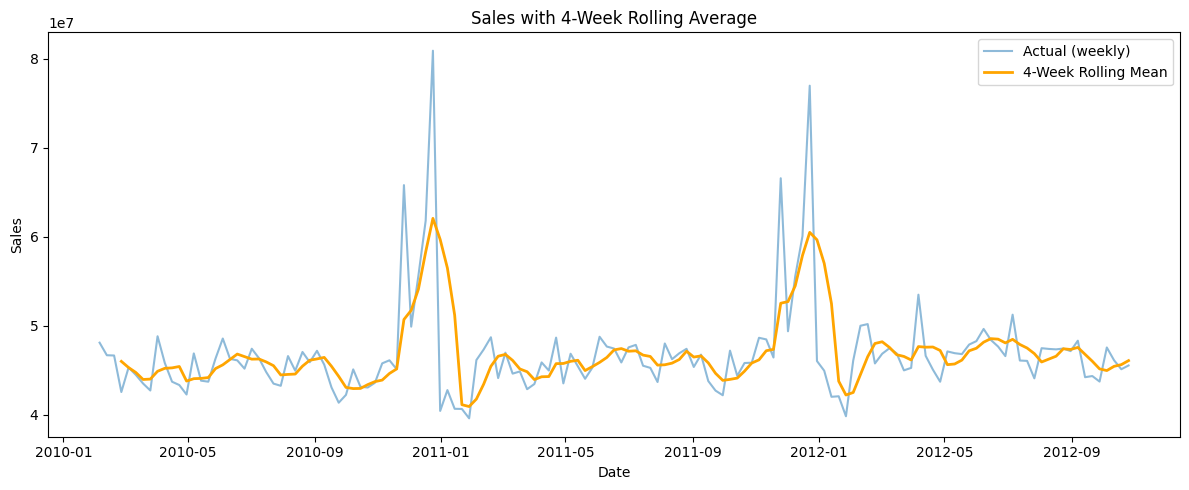

In [21]:
agg_df = df.groupby('Date')[target].sum().reset_index()
agg_df['rolling_mean_4w'] = agg_df[target].rolling(window=4).mean()

plt.figure(figsize=(12,5))
plt.plot(agg_df['Date'], agg_df[target], label='Actual (weekly)', alpha=0.5)
plt.plot(agg_df['Date'], agg_df['rolling_mean_4w'], label='4-Week Rolling Mean', linewidth=2, color='orange')
plt.title("Sales with 4-Week Rolling Average")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()



# Seasonal Decomposition

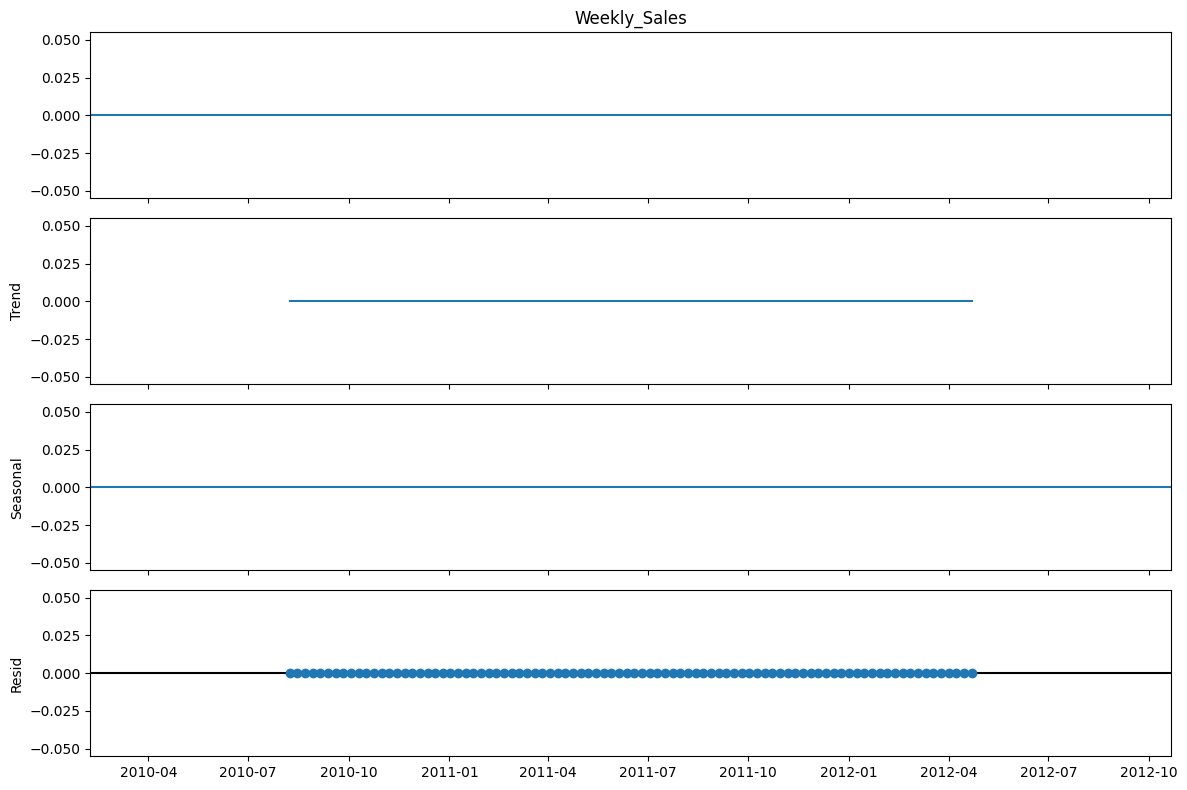

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

agg_df = df.groupby('Date')[target].sum().reset_index()

agg_df = agg_df.set_index('Date').asfreq('W')

agg_df[target] = agg_df[target].fillna(0)
result = seasonal_decompose(agg_df[target], model='additive', period=52)

fig = result.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()


# XGBoost/LightGBM with Time-Aware Validation

In [31]:
from xgboost import XGBRegressor

tscv = TimeSeriesSplit(n_splits=3)
model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)
    print(f"Fold {fold+1} RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.2f}")

model.fit(X_train, y_train)
y_pred_boost = model.predict(X_test)
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_boost)):.2f}")

Fold 1 RMSE: 237110.81
Fold 2 RMSE: 138543.35
Fold 3 RMSE: 286399.88
Test RMSE: 140206.89
